# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from buffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
import os
from utilities import transpose_list, transpose_to_tensor
import imageio
from collections import deque
import progressbar as pb
import matplotlib.pyplot as plt

In [6]:
## Hyperparameters
BUFFER_SIZE = int(1e6)               # max size of memory buffer
N_EPISODES = 20000                   # number of training episodes
EPISODE_MAX_T = 10000                # max timesteps each episode
BATCH_SIZE = 1024                    # size of batch
SAVE_INTERVAL = 1000                 # how many episodes to save policy
HIDDEN_NETWORK = [256, 256, 128]     # Structure of the hidden layer of the networks
LR_ACTOR = 1e-3                      # Learning rate of actor networks
LR_CRITIC = 1e-3                     # Learning rate of critic networks
ALLOW_BN = False                     # Allow Batch Normalization

NOISE = 2                            # amplitude of OU noise
NOISE_REDUCTION = 0.99995            # this slowly decreases to 0
EPISODE_PER_UPDATE = 1               # how many episodes before update

PRINT_EVERY = 100                    # how many episodes to print the medium scores
MOVING_AVERAGE_WINDOW = 100          # Size of moving average window

In [7]:
model_dir= os.getcwd()+"/model_dir"
model_path = os.path.join(model_dir, 'checkpoint.pth')
os.makedirs(model_dir, exist_ok=True)

In [8]:
def seeding(seed=948):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [9]:
def reset_env(env, brain_name, train_mode, verbose = False):
    # reset the environment
    env_info = env.reset(train_mode=train_mode)[brain_name]
    
    if verbose:
        # number of agents in the environment
        print('Number of agents:', num_agents)
        
        # size of each action
        print('Size of each action:', action_size)

        # number of actions
        action_size = brain.vector_action_space_size
        print('Number of actions:', action_size)

        # examine the state space 
        states = env_info.vector_observations
        state_size = states[0].shape[1]
        print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
        print('The state for the first agent looks like:', states[0])

    return env_info

In [10]:
def get_data_from_env_info(env_info):
    states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    
    return states, rewards, dones

In [11]:
def plot_scores(scores, moving_average_window=MOVING_AVERAGE_WINDOW, goal_threshold=0.5):
    moving_average = []
    moving_average_deque = deque(maxlen=MOVING_AVERAGE_WINDOW)
    for i in range(len(scores)):
        moving_average_deque.append(scores[i])
        moving_average.append(np.mean(moving_average_deque))
    
    goal_line_data = np.array([goal_threshold for i in np.arange(1, len(scores)+1)])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.bar(np.arange(1, len(scores)+1), scores, color='b', label='Scores')
    plt.plot(np.arange(1, len(scores)+1), moving_average, color='r', label='Average (last 100)')
    plt.plot(np.arange(1, len(scores)+1), goal_line_data, 'r--', label='Goal threshold') 
    
    #Here we got little help from:
    #https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [12]:
def watch_game(maddpg, n_episodes = 5, max_t = 200, random_seed = 0):
    agents = maddpg.maddpg_agent
    num_agents = len(agents)
    
    checkpoint = torch.load(model_path)
    
    # load the weights from files
    for i in range(num_agents):
        agents[i].actor.load_state_dict(checkpoint['agent_{}'.format(str(i+1))]['actor_params'])
        agents[i].critic.load_state_dict(checkpoint['agent_{}'.format(str(i+1))]['critic_params'])
    
    for i_episode in range(n_episodes):
        scores = np.zeros(num_agents)
        
        env_info = reset_env(env, brain_name, train_mode=False)
        states, rewards, dones = get_data_from_env_info(env_info)
        
        for t in range(max_t):
            actions = maddpg.act(states)
            actions_array = torch.stack(actions).detach().cpu().numpy()
            
            env_info = env.step(actions_array)[brain_name]
            states, rewards, dones = get_data_from_env_info(env_info)
            scores += rewards
            if np.any(dones):
                break
        
        print("Episode {0} winner agent reward: {1}".format(i_episode+1, max(scores)))

In [13]:
def main(env, maddpg):
    seeding()
    
    buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed=1)
    
    episode_scores = []
    episode_scores_deque = deque(maxlen=MOVING_AVERAGE_WINDOW)

    # show progressbar
    #widget = ['episode: ', pb.Counter(),'/',str(N_EPISODES),' ', 
    #          pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ' ]
    
    #timer = pb.ProgressBar(widgets=widget, maxval=N_EPISODES).start()

    noise = NOISE
    
    for episode in range(N_EPISODES):
        reward_this_episode = np.zeros(2)

        env_info = reset_env(env, brain_name, train_mode=True)
        states, _0, _1 = get_data_from_env_info(env_info)
        
        save_info = ((episode+1) % SAVE_INTERVAL) == 0
        
        for episode_t in range(EPISODE_MAX_T):
            actions = maddpg.act(states, noise=noise)
            noise *= NOISE_REDUCTION
            actions_array = torch.stack(actions).detach().cpu().numpy()
            
            env_info = env.step(actions_array)[brain_name]
            
            next_states, rewards, dones = get_data_from_env_info(env_info)
            
            states_full = np.concatenate([states[0], states[1]])
            next_states_full = np.concatenate([next_states[0], next_states[1]])
            
            experience = (states, states_full, actions_array, rewards, next_states, next_states_full, dones)
            buffer.add(*experience)
            
            reward_this_episode += rewards
            
            states, states_full = next_states, next_states_full
        
            if (np.any(dones)):
                break
                
        # update once after every EPISODE_PER_UPDATE
        if len(buffer) > BATCH_SIZE and (episode+1) % EPISODE_PER_UPDATE == 0:
            for a_i in range(2):
                samples = buffer.sample()
                maddpg.update(samples, a_i)
            maddpg.update_targets() #soft update the target network towards the actual networks

        
        efetive_episode_score = max(reward_this_episode[0], reward_this_episode[1])
        episode_scores.append(efetive_episode_score)
        episode_scores_deque.append(efetive_episode_score)
        moving_average = np.mean(episode_scores_deque)
        
        if (episode+1) % PRINT_EVERY == 0 or episode == N_EPISODES-1:
            print("Episode {0}\t Moving average(last {1}): {2:.4f}"
                      .format(episode+1, MOVING_AVERAGE_WINDOW, moving_average, noise))
            
        #timer.update(episode)     

        solved = False;
        if moving_average >= 0.5:
            solved = True
            save_info = True
            print("Solved in {0} episodes! Last moving average: {1}"
                 .format(episode+1, moving_average))
            
        #saving model
        save_dict = { 'episodes': episode, 'agent_1': {}, 'agent_2': {} }
        if save_info:
            for i in range(2):
                save_dict['agent_{}'.format(str(i+1))] = {
                             'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}

                torch.save(save_dict, 
                           model_path)
                
        if solved:
            break;
            
    #timer.finish()
    return episode_scores

In [14]:
maddpg = MADDPG(
    hidden_network=HIDDEN_NETWORK,
    lr_actor=LR_ACTOR,
    lr_critic=LR_CRITIC,
    allow_bn=ALLOW_BN,
    batch_size=BATCH_SIZE)

In [15]:
scores = main(env, maddpg)

Episode 100	 Moving average(last 100): 0.0060
Episode 200	 Moving average(last 100): 0.0019
Episode 300	 Moving average(last 100): 0.0027
Episode 400	 Moving average(last 100): 0.0010
Episode 500	 Moving average(last 100): 0.0039
Episode 600	 Moving average(last 100): 0.0040
Episode 700	 Moving average(last 100): 0.0199
Episode 800	 Moving average(last 100): 0.0050
Episode 900	 Moving average(last 100): 0.0069
Episode 1000	 Moving average(last 100): 0.0150
Episode 1100	 Moving average(last 100): 0.0280
Episode 1200	 Moving average(last 100): 0.0330
Episode 1300	 Moving average(last 100): 0.0240
Episode 1400	 Moving average(last 100): 0.0110
Episode 1500	 Moving average(last 100): 0.0240
Episode 1600	 Moving average(last 100): 0.0350
Episode 1700	 Moving average(last 100): 0.0480
Episode 1800	 Moving average(last 100): 0.0490
Episode 1900	 Moving average(last 100): 0.0450
Episode 2000	 Moving average(last 100): 0.0675
Episode 2100	 Moving average(last 100): 0.0739
Episode 2200	 Moving a

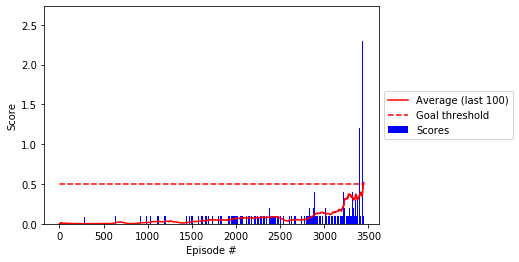

In [16]:
plot_scores(scores)

In [17]:
watch_game(maddpg)

Episode 1 winner agent reward: 0.5000000074505806
Episode 2 winner agent reward: 0.5000000074505806
Episode 3 winner agent reward: 0.5000000074505806
Episode 4 winner agent reward: 0.6000000089406967
Episode 5 winner agent reward: 0.5000000074505806


In [18]:
env.close()